<a href="https://colab.research.google.com/github/noobmaster-ru/numerical_methods_6sem/blob/main/numerical_methods_task_3_kozlov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README.hd
версия 8 мая 1:55

# Вычисление

## Импорт библиотек

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
import math
import matplotlib.ticker as ticker
from scipy.interpolate import interp1d
import time

## Задание начальных и граничных условий + константы

In [131]:
'''
Параметры сетки(чем больше,тем сильнее сгущение):
   •	c1 > 0: сгущение к левому краю отрезка
   •	c3 < 0: сгущение к правому краю
   •	c2 = 0: равномерно
'''
# при |c_module| >= 3.0 не сходится метод Зейделя
c_module = 2.00
c1 = c_module  # вправо ---> к точке разрыва pi/3
c2 = -c_module # влево к точке разрыва pi/3 <---
c3 = c_module # вправо ---> к точке разрыва 2pi/3
c4 = -c_module# влево к точке разрыва 2pi/3 <---

# N - количество узлов на каждом отрезке(то есть всего будет 4*N узлов)
N = 20

# Эпсилон окрестность для приближенного графика решения
eps = 0.2

In [132]:
# Задание коэффициентов
def p(x):
    if 0 <= x <= np.pi / 3:
        return (x - np.pi / 2) ** 2
    elif np.pi / 3 < x <= 2 * np.pi / 3:
        return x ** 2
    elif 2 * np.pi / 3 < x <= np.pi:
        return 0.1 + (x - np.pi) ** 2
def q(x):
    return 1.0
def f(x):
    if 0 <= x < np.pi / 2:
        return np.sin(x)
    else:
        return 1 + np.sin(x)


## Генерация сетки

In [133]:
def phi(t, alpha, beta, c):
    """Монотонная трансформация t ∈ [0,1] в [alpha, beta] с экспоненциальным сгущением"""
    if c == 0:
        return alpha + (beta - alpha) * t  # равномерный случай
    return alpha + (beta - alpha) * (np.exp(c * t) - 1) / (np.exp(c) - 1)

def generate_segment(alpha, beta, N, c):
    """Генерация сетки на отрезке [alpha, beta] с N интервалами, используя phi"""
    t = np.linspace(0, 1, N + 1)
    return phi(t, alpha, beta, c)


In [134]:
# Создание неравномерной сетки
def generate_grid(N, c1, c2, c3, c4):
    """
    Генерация неравномерной сетки на [0, pi], разбитой на 3 части:
    [0, pi/3], [pi/3, 2pi/3], [2pi/3, pi], каждая с экспоненциальной трансформацией
    Параметры:
      •	c1 > 0: сгущение к левому краю отрезка
      •	c3 < 0: сгущение к правому краю
      •	c2 = 0: равномерно
    """
    # Делаем 4 отрезка: [0, pi/3),[pi/3, pi/2),[pi/2, 2pi/3),[2pi/3, pi]
    x0 = 0
    x1 = np.pi / 3
    x2 = (2 * np.pi / 3 + np.pi / 3)/2 # == pi/2
    x3 = 2 * np.pi / 3
    x4 = np.pi


    grid1 = generate_segment(x0, x1, N, c1)[:-1]  # [0, pi/3)
    grid2 = generate_segment(x1, x2, N, c2)[:-1]  # [pi/3, pi/2)
    grid3 = generate_segment(x2, x3, N, c3)[:-1]  # [pi/2, 2pi/3)
    grid4 = generate_segment(x3, x4, N, c4)   # [2pi/3, pi]

    x = np.concatenate([grid1, grid2, grid3, grid4])
    return x

## Схема

In [135]:
# Дискретизация: центральные разности + интегральная форма
def build_matrix_and_rhs(x):
    N = len(x) - 1
    A = np.zeros((N+1, N+1))
    b = np.zeros(N+1)

    # Внутренние узлы
    for i in range(1, N):
      h_minus = x[i] - x[i-1]
      h_plus = x[i+1] - x[i]
      h = h_minus + h_plus

      pL = p((x[i] + x[i-1]) / 2)
      pR = p((x[i+1] + x[i]) / 2)

      A[i, i-1] = -pL / h_minus
      A[i, i] = pL / h_minus + pR / h_plus + q(x[i]) * h / 2
      A[i, i+1] = -pR / h_plus
      b[i] = f(x[i]) * h / 2

    # Граничные условия
    A[0, 0] = 1
    b[0] = 0  # u(0) = 0


    # Второй порядок аппроксимации краевого условия: p(x_N) * u'(x_N) + u_N = 1
    # u'(x_N) ≈ (3u_N - 4u_{N-1} + u_{N-2}) / (2h)
    hN = x[N] - x[N-2]  # можно также взять: hN = x[N] - x[N-2], но это уже влияет на порядок
    pN = p((x[N] + x[N-1]) / 2) # или p(x[N])

    A[N, N-2] = pN * 1 / (2 * hN)
    A[N, N-1] = -4 * pN / (2 * hN)
    A[N, N]   = 3 * pN / (2 * hN) + 1
    b[N] = 1

    return A, b

## Метод сопряженных градиентов

In [136]:
# гаусс , якоби , зейдель считаются слишком долго(или ошибку выдают) - поэтому выбрал градиенты
def conjugate_gradient(A, b, N ,tol=1e-6, max_iter=50000):
  x = np.zeros_like(b)
  r = b - A @ x # матрично-векторное умножение
  p = r.copy()
  rs_old = np.dot(r, r)
  for i in range(max_iter):
    Ap = A @ p
    alpha = rs_old / np.dot(p, Ap)
    x += alpha * p
    r -= alpha * Ap
    rs_new = np.dot(r, r)
    if np.sqrt(rs_new) < tol:
      # print(f"N = {N}, Сошлось за {i+1} итераций")
      return x
    p = r + (rs_new / rs_old) * p
    rs_old = rs_new
  raise ValueError("Метод сопряжённых градиентов не сошёлся")

## main


In [137]:
# Основной расчет
def solve_bvp(N):
  x = generate_grid(N,c1,c2,c3,c4)
  A, b = build_matrix_and_rhs(x)
  u = conjugate_gradient(A, b, N)
  return x, u

## Построение графиков

In [138]:
def plot_grid(x):
    plt.figure(figsize=(16, 2.0))
    plt.eventplot(x, orientation='horizontal', colors='blue', linewidth=1.2)

    # Вертикальные линии разрыва
    plt.axvline(np.pi/3, color='red', linestyle='--',dashes=(1, 1), linewidth=1.2, label=r'$\frac{\pi}{3}$')
    plt.axvline(2*np.pi/3, color='green', linestyle='--',dashes=(1, 1), linewidth=1.2, label=r'$\frac{2\pi}{3}$')

    # Настройка xticks
    tick_positions = [0, np.pi/3, 2*np.pi/3, np.pi]
    tick_labels = [r'$0$', r'$\frac{\pi}{3}$', r'$\frac{2\pi}{3}$', r'$\pi$']
    plt.xticks(tick_positions, tick_labels, fontsize=15)


    # Остальные настройки
    plt.title("Неравномерная сетка с экспоненциальным сгущением с узлами в точках разрыва", fontsize=20)
    plt.yticks([])
    plt.xlabel("Ось Ox",  fontweight='bold', fontsize=15)
    plt.grid(True, axis='x', linestyle=':', alpha=0.9)
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', alpha=0.35)

    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=15)

    plt.tight_layout()
    plt.show()
    print("\n")

In [139]:
def plot_solution(x,u):
    fig = plt.figure(figsize=(16, 8))
    plt.plot(x, u, label=f"u(x), N = {len(x)} узлов", color="blue", linewidth=1.5)
    # plt.plot(x, u, 'o', color='black', markersize=4,alpha=1.0)

    # Добавим вертикальные линии в точках разрыва
    plt.axvline(np.pi/3, color='red', linestyle='--', linewidth=1.0)
    plt.axvline(2*np.pi/3, color='green', linestyle='--', linewidth=1.0)

    # Добавим маркеры в этих точках, если они присутствуют в сетке x
    for xi, color in [(np.pi/3, 'red'), (2*np.pi/3, 'green'), (x[0], 'black'),(x[-1], 'black')]:
        idx = np.argmin(np.abs(x - xi))
        plt.plot(x[idx], u[idx], 'o', color=color, markersize=7, label=fr'$u(\frac{{{int(round(xi/np.pi*3))}\pi}}{{3}})$')

    # Оформление осей
    plt.xlabel("Ось x", labelpad=10, fontsize=20, fontweight='bold')
    plt.ylabel("u(x)", rotation=0, labelpad=10, fontsize=20, fontweight='bold')
    plt.title("Численное решение краевой задачи", fontsize=20)

    # Подписи оси X
    tick_positions = [0, np.pi/3, 2*np.pi/3, np.pi]
    tick_labels = [r'$0$', r'$\frac{\pi}{3}$', r'$\frac{2\pi}{3}$', r'$\pi$']
    plt.xticks(tick_positions, tick_labels, fontsize=15)

    # Сетка
    plt.grid(True, color='gray', which='both', linestyle='--', linewidth=0.6, alpha=0.95)
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', linewidth=0.6, alpha=0.5)

    # Легенда
    plt.legend(fontsize=15)
    plt.tight_layout()
    plt.show()
    print("\n")

In [140]:
def zoom_around_discontinuity(x, u, x0, eps, point):
    """
    Визуализация решения на участке [x0 - eps, x0 + eps]
    """
    # Подсчёт количества узлов в подотрезке
    x_left = x0 - eps
    x_right = x0 + eps
    mask = (x >= x_left) & (x <= x_right)
    num_nodes_in_segment = np.sum(mask)
    mask = (x >= x0 - eps) & (x <= x0 + eps)
    x_zoom = x[mask]
    u_zoom = u[mask]

    plt.figure(figsize=(10, 6))
    plt.plot(x_zoom, u_zoom, '-',color='blue', linewidth=2, label=f"u(x), N = {num_nodes_in_segment} узлов")


    if point =="pi/3":
      label = r'Узлы в $[\frac{\pi}{3} - \varepsilon, \frac{\pi}{3} + \varepsilon]$, ' + fr'$\varepsilon = {eps}$'
      plt.plot(x_zoom, u_zoom, 'o', color='black', markersize=6, label=label,alpha=1.0)

      # Вертикальная линия в точке разрыва
      plt.axvline(x0, color='red', linestyle='--', linewidth=1.2, label=r'$x = \frac{\pi}{3}$')
      plt.title(r"Приближение к точке разрыва $x = \frac{\pi}{3}$", fontsize=15)
      plt.xlabel("Ось x", fontweight='bold', fontsize=15)
      plt.ylabel("u(x)",rotation=0, fontweight='bold', fontsize=15)

      # Подписи оси X
      tick_positions = [x_left,x0, x_right]
      tick_labels = [r'$\frac{\pi}{3}-\varepsilon$',r'$\frac{\pi}{3}$',r'$\frac{\pi}{3}+\varepsilon$']
      plt.xticks(tick_positions, tick_labels, fontsize=15)

      # Сетка
      plt.grid(True, color='gray', which='both', linestyle='--', linewidth=0.6, alpha=0.95)
      plt.minorticks_on()
      plt.grid(True, which='minor', linestyle=':', linewidth=0.6, alpha=0.5)

      plt.legend()
      plt.tight_layout()
      plt.show()
      print("\n")
    else:
      label = r'Узлы в $[\frac{2\pi}{3} - \varepsilon, \frac{2\pi}{3} + \varepsilon]$, ' + fr'$\varepsilon = {eps}$'

      plt.plot(x_zoom, u_zoom, 'o', color='black', markersize=6, label=label,alpha=1.0)

      # Вертикальная линия в точке разрыва
      plt.axvline(x0, color='green', linestyle='--', linewidth=1.2, label=r'$x = \frac{2\pi}{3}$')
      plt.title(r"Приближение к точке разрыва $x = \frac{2\pi}{3}$", fontsize=15)
      plt.xlabel("Ось x", fontweight='bold', fontsize=15)
      plt.ylabel("u(x)",rotation=0, fontweight='bold', fontsize=15)

      # Подписи оси X
      tick_positions = [x_left,x0, x_right]
      tick_labels = [r'$\frac{2\pi}{3}-\varepsilon$',r'$\frac{2\pi}{3}$',r'$\frac{2\pi}{3}+\varepsilon$']
      plt.xticks(tick_positions, tick_labels, fontsize=15)

      # Сетка
      plt.grid(True, color='gray', which='both', linestyle='--', linewidth=0.6, alpha=0.95)
      plt.minorticks_on()
      plt.grid(True, which='minor', linestyle=':', linewidth=0.6, alpha=0.5)

      plt.legend()
      plt.tight_layout()
      plt.show()
      print("\n")

## Визуализация

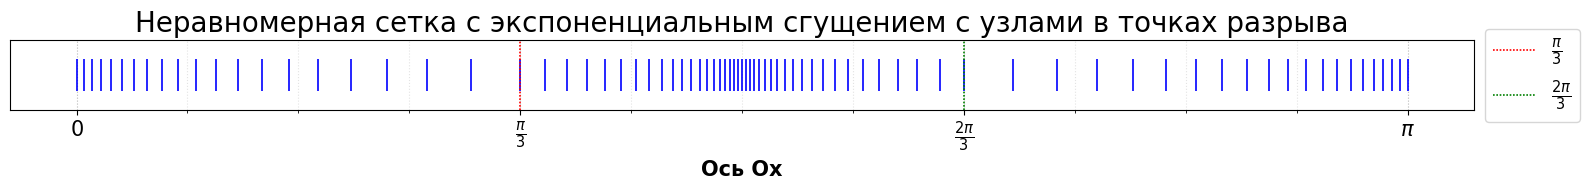

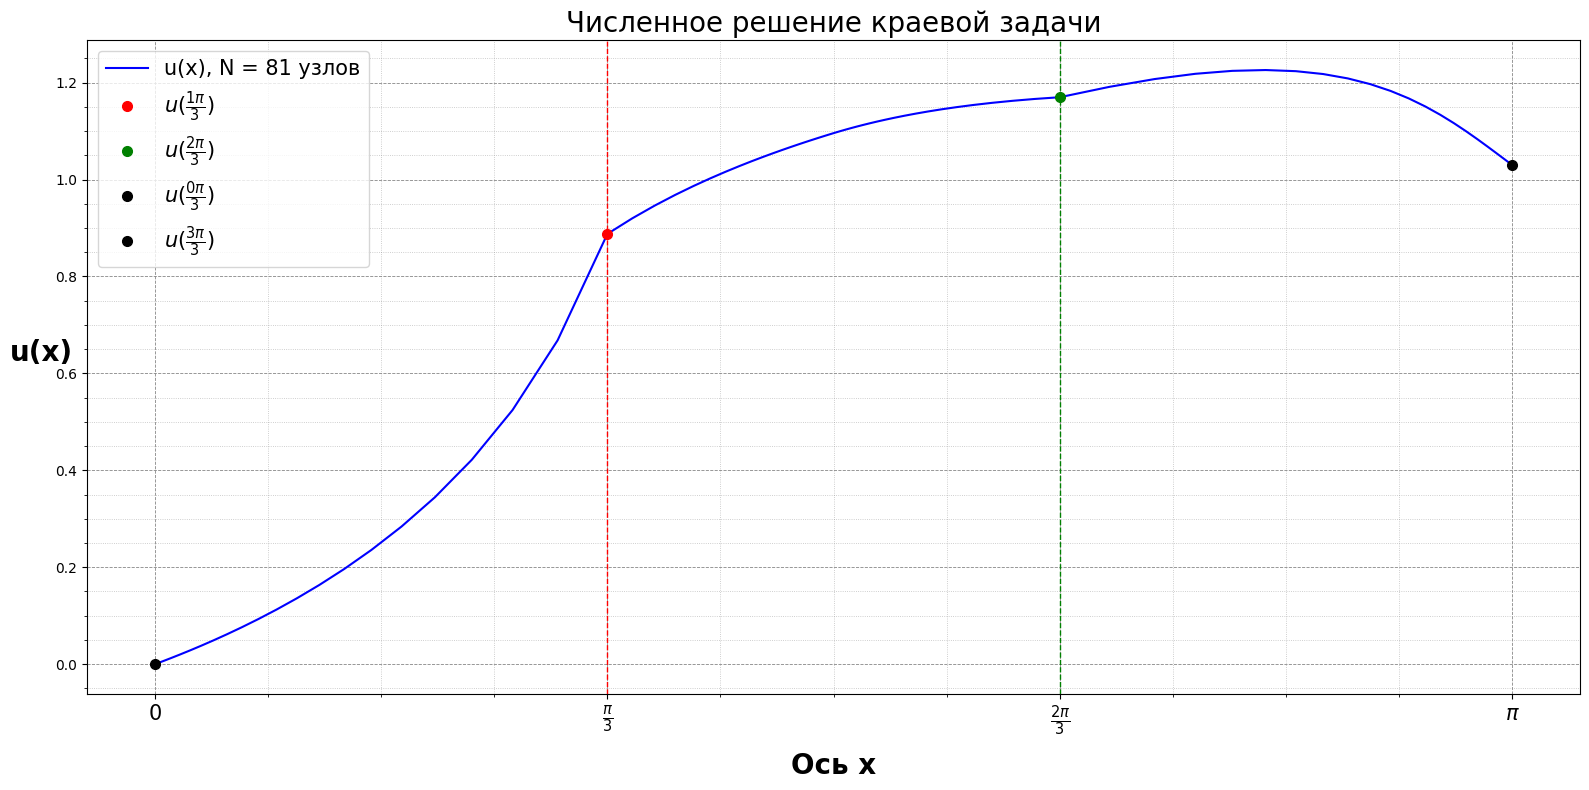

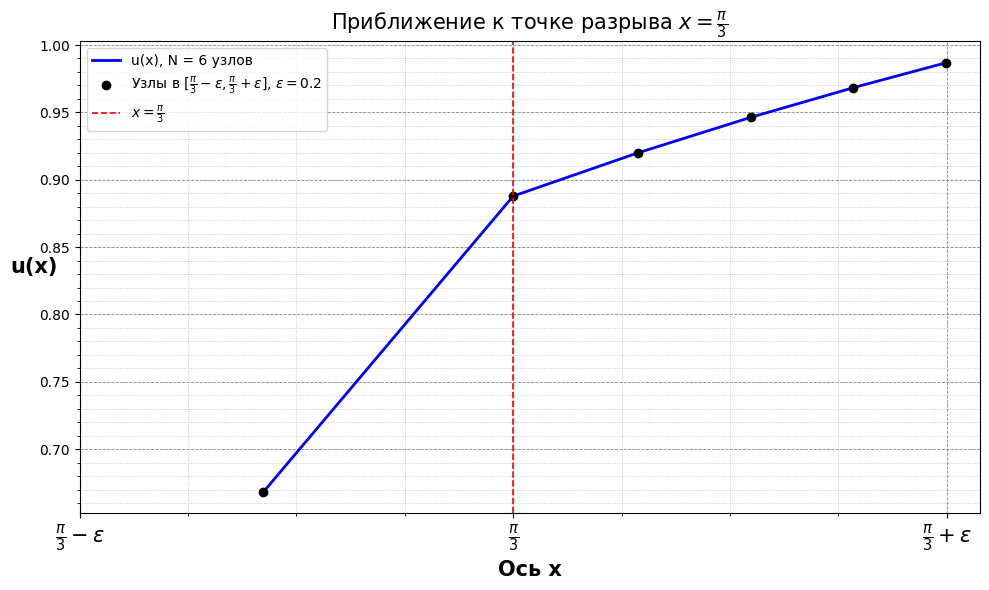

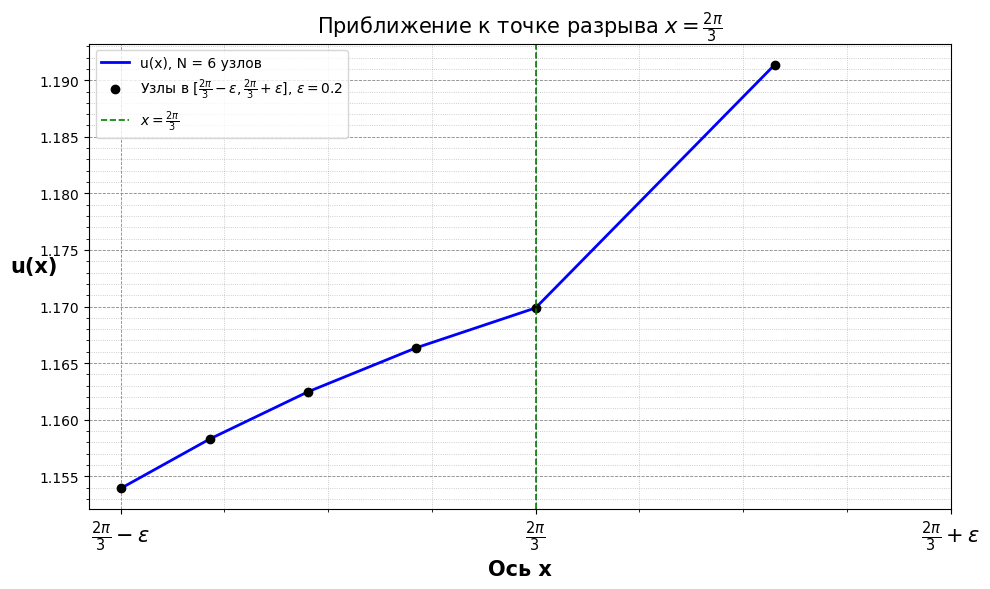

In [141]:
x, u = solve_bvp(N)

plot_grid(x) # Сетка
plot_solution(x,u) # Решение

# Приближение решения в окрестноти точек разрыва
zoom_around_discontinuity(x, u, np.pi/3, eps, "pi/3")
zoom_around_discontinuity(x, u, 2*np.pi/3, eps, "2pi/3")

# Оценка сходимости методом Рунге

In [142]:
def max_norm_error(x_true, u_true, x_fine, u_fine):
    interp = interp1d(x_fine, u_fine, kind='linear')  # не получалилось сравнить точные узлы(не знаю почему ошибку выдаёт), поэтому взял интерполяцию
    max_err = np.max(np.abs(u_true - interp(x_true)))
    return max_err

In [143]:
# Истинное решение
def true_solve(N=10000):
  # x = generate_grid(N,c1,c2,c3,c4) # - на неравномерных сетках не получается сделать, перегрузку выдаёт
  x = np.linspace(0, np.pi, N + 1)
  A, b = build_matrix_and_rhs(x)
  u_solve = solve(A, b)
  return x, u_solve

In [144]:
# Численный расчет для метода Рунге - неравномерные сетки
def runge_unequal(N):
  x = generate_grid(N,c1,c2,c3,c4)
  A, b = build_matrix_and_rhs(x)
  u = conjugate_gradient(A, b, N)
  return x, u

In [145]:
# Численный расчет для метода Рунге - равномерные сетки
def runge_equal(N=10000):
  x = np.linspace(0, np.pi, N + 1)
  A, b = build_matrix_and_rhs(x)
  u = conjugate_gradient(A, b, N)
  return x, u

In [146]:
# Метод Рунге для оценки порядка (неравномерные сетки)
def runge_convergence(N_coarse, equal_grid ,r = 2):
  if equal_grid:
    x_n, u_n = runge_equal(N_coarse)
    x_2n, u_2n = runge_equal(N_coarse * r)
    x_4n, u_4n = runge_equal(N_coarse * r * r)
  else:
    x_n, u_n = runge_unequal(N_coarse)
    x_2n, u_2n = runge_unequal(N_coarse * r)
    x_4n, u_4n = runge_unequal(N_coarse * r * r)

  x_true, u_true = true_solve()
  r2 = r*r
  norm_n = max_norm_error(x_true, u_true, x_n, u_n)
  norm_2n = max_norm_error(x_true, u_true, x_2n, u_2n)
  norm_4n = max_norm_error(x_true, u_true, x_4n, u_4n)
  rate = np.log2((norm_n - norm_2n) / (norm_2n - norm_4n))
  return  rate

## Метод Рунге

In [147]:
# Оценка сходимости - на неравномерных сетках не получается сделать (истинное решение не считается - переполнение ОЗУ)
#   поэтому делал на равномерной сетке при N = 10000
# Считает 2-3 минуты
Ns = [30, 40, 50, 60, 70]
print("     Метод Рунге (неравномерные сетки)\n")
print(f"c1 = {c1}, c2 = {c2}, c3 = {c3}, c4 = {c4}")
start_time = time.time()
for N in Ns:
  rate = runge_convergence(N,False) # считает долго из-за N=10000 в true_solve - истинное решение считаем
  print(f"N={N}: порядок аппроксимации p ≈ {rate:.3f}")
end_time  = time.time()
work_time = end_time - start_time
minutes = int(work_time // 60)
seconds = int(work_time % 60)
print(f"\nВремя работы: {minutes} мин , {seconds} c")

     Метод Рунге (неравномерные сетки)

c1 = 2.0, c2 = -2.0, c3 = 2.0, c4 = -2.0
N=30: порядок аппроксимации p ≈ 1.712
N=40: порядок аппроксимации p ≈ 1.975
N=50: порядок аппроксимации p ≈ 2.283
N=60: порядок аппроксимации p ≈ 2.343
N=70: порядок аппроксимации p ≈ 2.077

Время работы: 2 мин , 20 c


In [148]:
# порядки нетипичные - при N = 40,70,100,200 только близко к 2 - тк берет не точное значение, а интерполяцию
Ns = [10, 20, 30, 40, 50, 60, 70, 100 ,200]
print("     Метод Рунге (равномерные сетки)\n")
start_time = time.time()
for N in Ns:
  rate = runge_convergence(N,True) # считает долго из-за N=10000 в true_solve - истинное решение считаем
  print(f"N={N}: порядок аппроксимации p ≈ {rate:.3f}")
end_time  = time.time()
work_time = end_time - start_time
minutes = int(work_time // 60)
seconds = int(work_time % 60)
print(f"\nВремя работы: {minutes} мин , {seconds} c")

     Метод Рунге (равномерные сетки)

N=10: порядок аппроксимации p ≈ 0.728
N=20: порядок аппроксимации p ≈ 0.462
N=30: порядок аппроксимации p ≈ 0.989
N=40: порядок аппроксимации p ≈ 1.561
N=50: порядок аппроксимации p ≈ 0.342
N=60: порядок аппроксимации p ≈ 0.966
N=70: порядок аппроксимации p ≈ 1.622
N=100: порядок аппроксимации p ≈ 1.617
N=200: порядок аппроксимации p ≈ 0.427

Время работы: 3 мин , 53 c


# Итого

### Тесты

     Метод Рунге (неравномерные сетки)

c1 = 2.0, c2 = -2.0, c3 = 2.0, c4 = -2.0 \\
N=30: порядок аппроксимации p ≈ 1.674 \\
N=40: порядок аппроксимации p ≈ 1.696 \\
N=50: порядок аппроксимации p ≈ 1.807 \\
N=60: порядок аппроксимации p ≈ 2.047 \\
N=70: порядок аппроксимации p ≈ 2.390 \\

Время работы: 2мин , 24c

     Метод Рунге (равномерные сетки)

N=10: порядок аппроксимации p ≈ -0.334 \\
N=20: порядок аппроксимации p ≈ 1.353 \\
N=30: порядок аппроксимации p ≈ 1.252 \\
N=40: порядок аппроксимации p ≈ 0.674 \\
N=50: порядок аппроксимации p ≈ 1.237 \\
N=60: порядок аппроксимации p ≈ 0.953 \\
N=70: порядок аппроксимации p ≈ 0.738 \\
N=100: порядок аппроксимации p ≈ 0.736 \\
N=200: порядок аппроксимации p ≈ 1.349 \\

Время работы: 3мин , 49c

true_solve не получается посчитать на неравномерной сетке - выдаёт переполнение. Поэтому искал на равномерной сетке при N = 10000 и потом уже брал с помощью interp1d() - тк не смог взять точное значение в узлах(не знаю почему)